In [1]:
import csv
import subprocess
import shlex
import json

import numpy as np

from io import StringIO
from matplotlib import pyplot as plt
from scipy.stats import kstest, expon, combine_pvalues
from IPython.display import display, Markdown
from tqdm import tqdm

In [2]:
target_directory = json.loads(subprocess.run("cargo metadata --format-version 1".split(), capture_output=True).stdout)["target_directory"]

# Speciation Time Test

In [3]:
def test_speciation_time(
    algorithm, speciation=0.001, seeds=[42], radius=25, sample=1.0
):
    total_pvalues = []
    total_speciations = []
    
    for seed in tqdm(seeds):
        # Configure the simulation
        # (tested on almost infinite with sigma 0 to avoid bias from coalescence)
        config = "".join("""
        (
            speciation: {speciation},
            seed: {seed},
            sample: {sample},

            algorithm: {algorithm}(),

            scenario: AlmostInfinite(
                radius: {radius},
                sigma: 0.0,
            ),

            reporters: [
                Plugin(
                    library: "{target_directory}/release/deps/libnecsim_plugins_statistics.so",
                    reporters: [
                        GlobalSpeciation(output: "{output_file}"),
                    ],
                ),
            ],
        )
        """.format(
            target_directory=target_directory, output_file="/dev/fd/2",
            algorithm=algorithm, speciation=speciation, seed=seed, sample=sample, radius=radius,
        ).split()).replace(",)", ")").replace(",]", "]")

        # Run the simulation
        speciations_io = StringIO(subprocess.run(shlex.split(
            "cargo run --release --features rustcoalescence-algorithms-monolithic,"
            + f"rustcoalescence-algorithms-independent --quiet -- simulate '{config}'"
        ), check=True, capture_output=True, text=True).stderr)

        # Read in the speciation times
        speciations = []
        with speciations_io:
            reader = csv.reader(speciations_io)
            next(reader)

            for row in reader:
                speciations.append(float(row[0]))
        speciations = np.array(speciations)

        # Calculate in the dispersal locations
        gof = kstest(speciations, expon(loc=0.0, scale=2.0/speciation).cdf)
        
        total_pvalues.append(gof.pvalue)
        total_speciations.append(speciations)
    
    gof_statistic, gof_pvalue = combine_pvalues(total_pvalues)
    
    if gof_pvalue <= 0.01 or gof_pvalue >= 0.99:
        display(Markdown(f"## <span style='color:purple'><u>{algorithm}</u></span>"))
    elif gof_pvalue <= 0.05 or gof_pvalue >= 0.95:
        display(Markdown(f"## <span style='color:red'><u>{algorithm}</u></span>"))
    elif gof_pvalue <= 0.1 or gof_pvalue >= 0.9:
        display(Markdown(f"## <span style='color:orange'>*{algorithm}*</span>"))
    else:
        display(Markdown(f"## <span style='color:green'>{algorithm}</span>"))
    
    display(Markdown("#### Fisher’s combined KS test:"))
    display(Markdown(f"\n* p-value: {gof_pvalue}\n* statistic: {gof_statistic}"))
    
    plt.title("Distribution of p-values")
    plt.xlabel("p")
    plt.ylabel("pdf")
    plt.hist(total_pvalues, density=True)
    plt.show()
    
    display(Markdown("#### Speciation histograms:"))
    
    speciations = np.concatenate(total_speciations)
    
    # Draw the speciation time histograms
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    x = np.linspace(np.min(speciations), np.max(speciations), 1000)
    loc, scale = expon.fit(speciations)
    
    ax1.set_title(f"Individual speciation times PDF")
    ax1.set_xlabel("speciation time")
    ax1.set_ylabel("pdf")
    ax1.plot(x, expon.pdf(x, 0.0, 2.0/speciation), color='red', linewidth=2, alpha=0.5, label=f"expected: loc=0.0 lambda={speciation * 0.5}")
    ax1.hist(speciations, bins = 1000, density=True, label=f"observed: loc≈{round(loc, 3)} lambda≈{round(1.0/scale, 3)}")
    ax1.legend()
    
    ax2.set_title(f"Individual speciation times CDF")
    ax2.set_xlabel("speciation time")
    ax2.set_ylabel("cdf")
    ax2.plot(x, expon.cdf(x, 0.0, 2.0/speciation), color='red', linewidth=2, alpha=0.5, label=f"expected: loc=0.0 lambda={speciation * 0.5}")
    ax2.hist(speciations, bins = 1000, density=True, cumulative=True, label=f"observed: loc≈{round(loc, 3)} lambda≈{round(1.0/scale, 3)}")
    ax2.legend()

    plt.show()
    
    display(Markdown(f"#### Parameters:\n* seeds: {seeds}"))
    
    display(Markdown(f"#### Configuration:\n```rust\n{config}\n```"))

100%|██████████| 1000/1000 [12:43<00:00,  1.31it/s]


## <span style='color:green'>Classical</span>

#### Fisher’s combined KS test:


* p-value: 0.8711425580594059
* statistic: 1928.6168390482044

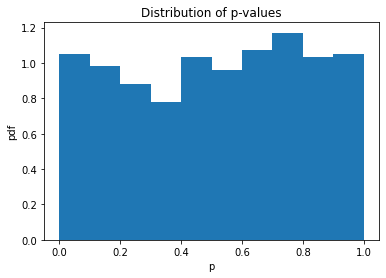

#### Speciation histograms:

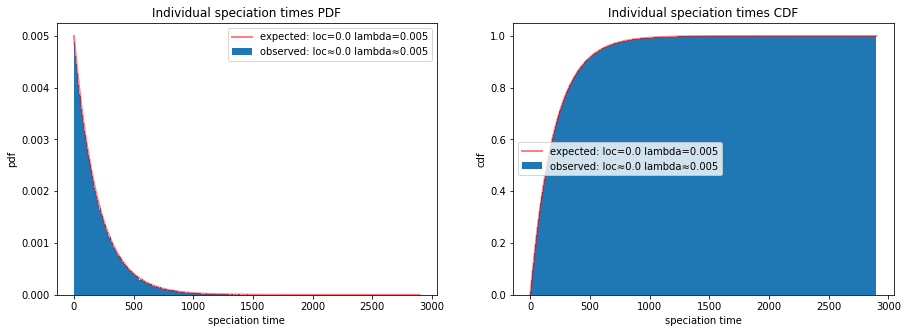

#### Parameters:
* seeds: [ 7714778522532582362 16673264403859871918  5538861533520164187
  2357613501641814217 16356854471997033774 14571982832211027910
  2364946376265453211  4537697225561441949  8570690881361021646
 15305916600822731075  8132635925650740011  5889153098380350063
  9693548982659208167  1933285311244231188  7330704993941822486
 17159828351077181592  2310136154749197074   892273353109237452
 14267062901813625465 11404940389048683510 16448842819371536924
  5611270179509013644 17286818436070993259 10739237679286084811
  7426151474967088814  3720599957686033611  6077053531761622241
 11724841551930340772 18215239195583296607 10985301577052209027
 11138612786301898849  3059266386955523350  6702890157519143510
 12765106634582087392 13014867895039824987 14806521644096446006
 14067544546002554595 15232839935563227445  7166939052845658269
 17597672103856620308  1224813923347338909  7387707623883613853
  1897662069027358409 14128267127611561061  2417895552723089915
  1218702573123752124  1704164252949819624  2847267426034513312
  2709907407587128477 10786521406563849503 12960619542658144635
 16144988358294030566  1327216392834644320  3586150052756196905
  3990402665678845340 13543587043090227731  8827139089657424008
 18079923388863326661 17656135588024618195 15763887867180699352
 10648845112115824237  6260806450665003663  4195224191098912262
  4209176291582097074  6814180206191124981 10686473963580960352
 18153715345287537738  5631220736463509830  6317250500188559698
 16711810017532069038  9010589366681595365 13612152923216910102
   657713447275335466  1544604195743453131 12318035797175111613
 15564301852895708431 10583269245946120947 16954399384143667312
  5356855350165168299 13544260932752215277  9265963149892802930
  7148967583672667277 14735945083095849981 18330906973365900996
  6663302421172482851 10062777818193711562 14738517303003192863
  2679474093086176158 16710778487263314182  4715887223738488240
  5616889302307391559  4501797629443001400   419849533397039681
  1930240444229239307  7822075334207992376 16439195035800036658
   529059577960114488 11513971119765922243  5396559047480077206
 16296009414774758643 14396018751759272383 17167145032312496551
  5097061587314149433 15150571730094935697 12419291512099675675
 11705014090655630708 14401761514223315246  4673370438242488490
  4049327592579041118 17283157191679831674 12773945583102740309
   398312534003092872  6864826887857908819 11038331212128174137
 15307328501852660545  4508376633261546786  6600615516455717067
 15431057032415339436  8607421375645681333 17352757911020382228
  7501834233118477728 14633910538112348459  8595807680803580810
 15714997875078320360 14846591951284632101 18170068303970973158
 12626225438065388552    51556341559058649  1424027562068249073
 14660616508739271278  1884613005077650686 17480146141590877557
  3828583120343049934  9172986269611657448  2637652329676812158
  8200922864936716464  4971215861995324974 17573321502656813324
  1911498124504258781  5621197783879024694  4689400922560912322
  8730229920623386122  3971849451305638690 13913677963890620205
 12064000508695863029  7175587908198264347  4409758891990726841
 11272147615442309195 11299114473090096559 17789310596571154461
  7338392991877471228  1867182601076760717 15354624261144656237
 15177511488612074714 17043160085253831528  3200291647694342810
 10866669071023401160 10527666436974405076  5646066384949970566
  5648719638688612529 10574542948069934021 16797344858975772079
  7930313800831260300   742917587267291296  2412628261975951360
 15048586988360751459  6161284422550789943 13963266120224672655
 14302811754102978259  4579083599879194640 17603913097863667725
  1843779978467660938  9286451123063698789  5120241595670657897
 15215682512319068229  7455119357405915372  3364907397542528737
  4885405077459746907  9851075151689742128 12761156982442442045
 15734618786888805197  5331481069898725234 13406861955780184636
 11689431308132171893 12635233944682208479 12813812011811765243
 17467572558148494894 17681779823874663414  7561094747335635432
  1420139779733753786   595424413255637057 17557786013422250005
  1883769147398926273  5833238525831290932  1773692810857562345
  8385289898587940157 14609477657238091204 16366504932788055793
 10498697908551961388 14637290447791226111 17507314359135144254
  4483675668437427077 10751542072660769137 10973846165481366928
  4358424301932312245  3343027930928169601   196285924823469415
 15283736268997664621  8945227734199259581 13529434950203011656
  6584376084418137874 12182945227305030190  2385213809791339466
  3312872895930338390  5661956481838842589   166140773826207165
  2713119579886014494  3579705823288632972   316278603796808850
   464506534017084368  2882522087229374580  1226322839741515697
 10528812586854493177 16328406422569453041 11761143689665543205
 11140738541202457885  6968212414487590248   972278720628262668
   303063795041151167  6447374171617713658 13738899028308071942
 10782819639052399128  7699097273936617390  6971846719346460583
 11526793335688550232  2674531741377214670 14956154016504655705
 18273297686720300687 18382416040985123606  5236549737657924635
  4251510360313730398  4272933712284816675 14163013996405781874
 17350657114852139655  4898646715751023180  3329130255199063737
 17857479771463518561 13032617510813301174 10852388530920398549
 14968564007166061231  4805776570419277749  5351423321756577702
  1604548017267167227   400603388986690071 12325121301504767212
 14384311432633013486  6409257522156543697  6271829603815675606
  9633185263378357053 17809959168818796142  9658591549660342492
  2283008403234898084 16424026640038185093  3516384374661949849
  2542766377252088875 11352241180220881253 11837796843300755070
 13089822948418068952  2346191865185076159 17879314907442487972
 16356880178493726873 13398385611901985563  7345853606428162573
 15663350811695035871 10867242133907360216 13181146820352221711
  1384961555409120495  8756833699818682239 14303467890420514719
 17138265124348113514  2292289939457232539  2554330031461915043
 17519904625038517845 15330641513349664215 10268615187451012366
  7192879861198883179  5832586152257601114 11808856261565780813
  3795057902914029755 15233072389582662796  2471229115712988422
  9318502214615978820  1596028855101926320 12609055643537486336
 16326818329155586666 10371695446474895894   614951136662183340
  4757491863856049252   124162832658402700 16207785089192666928
  3158799072518064480  4570090592381853143   539811889567994423
  6006992973102770384 18177543213442835118 13132392170670845239
 14868978489038286846 15888599479841379613  7127844080553476048
 11609045191502054761  1664695373820485302 14557697494941317988
  7167966187975708026 11343954485134927025  1088527998714974002
  4782116125674333172 14220690708007242151  4036484762481332004
 14690066942725560258  7037485837189306219 15122677398589864413
 14100839183286222063 18029313837675858376  2375142987615658556
  3171976132826936233  7111223588130969980 10419465531157326042
 17812175744071354894  1909292594008458883  3754682028333998571
  8870392435987763043  6100312943402964237 10052374934955983590
  1467990684607822126  7993454787254074160 12388908084969166138
 12968265631635817513  9235140849642565647 12246119896378392545
  5001430135582295913 10333148535013737206 14188424384353287139
 10454173475163136548  9976954249054386066  3283825298901498528
  1412878988117257583 15865240088286143587  3757294887611332653
 15123851009043225215  8623882398286130994 14183513557042554133
  8289604849600991664  5687107204880304674 11083538282109614223
  8587691734323887357   462171231250779509 13623379407038145764
 15060492059226279597 11657261016995134393 12795983173761448055
 11149421873853549786 18075768202082770168  6748503757892141314
  3100343193479873948  7537091574229135324  8657899295643492519
 15801214842678293247 16439519583879537415  8062202396317465923
 16427807353547705356 14724850092606927562 18199356253576679667
  1531941185013587986  5240624591036084917  5306980389414125718
   534576756449557158  3599082481394410176  9528761587977836143
 15741410888133683590 10436076241764808409  5017461479977261900
 12840627666893765924 10895100777667280566 13645332894774448002
  1212636588323131755 15159528471186605815  2257630146673904790
  5442178984405897218 17205136414454307583  4203461555621043586
  1747399930097715466  2643258803966207551  3101615293654012053
  1754068510504155594 15958143403751356678  3304413289180223509
  7552573614213229874  1092142797910800014 13141264831167155578
 15825846523643252002   578759193796889514  2080611919991882110
 16772467383021177030  8335020516610154718 14949439746192671712
 10240135600603363747  6021323519774703459  9701181534632932388
 11862763532274408051  9950936070276129678  6187543333979977401
 13223329137255198601  5062128169003534802  6120573078001340522
  9358634306374059691 13499784375661291737 10792281788138162119
  1466123923001173170  3292177083075237583  1155854407463368509
  9971326167666297358  9744205558712809281  9318307683319678459
  5265025486812430611 15531842703363011327  6754423846580821883
  3926655856662485680  1960517333399648958 18389976753511805290
 14685449704744727608  3806781597424049630  2979246814267684070
 10275439324830245108 17667262848333663410  8584360425677333844
 13537637476660429166  1861448093858871288 11724235797026080865
  5753595245887264724 10439571032949948091   942168776551737765
 12589892402428846178 15665963975006465679 11057461005536547497
 15223182279443646058 13546815451535569039  8540891836656389270
  3613831980678734535  2958213768023409862 16925879335210677935
  3482101398521551514 14008337164679801778  8240177590439847101
 12753976720520417320   261149339256999816  2035168639704420961
  2862528444323898734 12316693789344376090 13558451600178499951
  3899766939988954934  6617323339961044049 12899226913232505482
 16850509825032311177 12911451408208209520 17989474493708374878
   557840671215120985  4214008470406888843  4329344231824909523
 11697806416882293078 18059551623025217105  2788549872035881271
  3625001768827827820 14071406809429731383 17919624384080255786
  2925601460520037371 14682811497468925322  2863833385801883543
   430793603755903248 11791474165171326065 11944541733830199434
  2621628844276481252   120474152939581393  5214037287858978475
  9657362374195883624   923841719158827614   592466909495478504
  3694991243516403132  5435992240506960385  2873106571404433421
  2330238411972368800 15166348921471604329  2786415384853091025
  2728743951711487003 12063658140974013780  5789614550503511288
 17140814564149427678  7860976241692568890   226315314745878983
   202599032623218937  3053314223004250650   835462127888858735
 13050157882194052041  2988042143698967107  7280245759343140837
  7248738749546894599  8290226771442512887 16377987704495233732
  4458108680841936131   350295308849646191  7021706254153111193
 10746259428988034807  7261170174519695133  9779927382751233943
 16327015997971971215 16606963038770119537  6340681565907574290
  9195503177695489505  8174385643804219701 10793774444438218960
  2779039863941902680  2684450360297251644 13461742180149934115
   531723182770836007  7649423863619459015 17105418500187692476
  6053493031747976867  9972254833332886833  1164269158777747540
  3700450632988999169 16924043043717069750  3407269773024631167
  5743704196356398870   939697024154983681 15404506967391400178
 12049876018078149266   450507931427201639   237048852316085092
  6740708037641882027  9271574019302691207 15381084582785672533
 15647055642517584026  3518701424776158734 16402038747811934390
 12491088135624464502  9688058006251148635   627294833455277726
 17963420510445567784 14035308930314915923 12164666410238963886
  5091801104594856345   391558569983199327  5449773735788945684
  3758933160296137698  1689964055153760097 12030288374109717406
  3869809258798144520 17340153046755453746  3682821139683408604
  4818396186654281956 16015829829488415099 18341822502608202606
  7489085594393068306  9554769692992031653 18037106958148234085
  8007689995410048876 13958047500413451938 17501243309212193424
 13279817188388878954  7972470728806413623  8095239116338549201
  4573842036563200678 16938434387986254855  5802093302393477845
  9049958398059271694 11671811902297727626 11844374859944509339
 12514620710787100808 10526772488957810551  3159406593427549350
  6458595279945809188 14574247218092440116  9940378964451197481
  3109016632472840410  4661347479647440691  5246042849405309636
 14600725310176198767 13253872779877091314 11822731463103781527
   647669450322020979 10397685226243758001  6253343284724357770
  6185288022111847237  2692037800586348949  9837540877755704256
  9335068819976925719  7297960625511562971 13096227415365192496
  8549272609543671841 10779099053034661203  3138188451304606192
  3886974834133291549  9215534369921501763  7715755255396326272
  7525416201166481237    54453649995284600  9008885508573379078
 11197663887255280589  6115283512213878192  4658541009920971551
  1276728900572669307 17183635016774130478 17121653568043004500
 13112526772159333993  8337629013639913241 14670306435201443040
  9588646121386320246  8227560575166070985 15931101879620925979
 11235427315901129939 10118484690656616583 17147905189374509518
 13628675359259450640   111327993345649883  2464491163814804446
 13770008767195357492 17716836116395165557 18237568506503764687
 14079521569323240522  3125315765780294828 17254030904590587862
  9462093669917962303 12406159107154200423 17557333166712362781
  3867314326298026747  2766093303677503475  5101803028401968639
 12839066744253700363  9975475249558112451 10885515140604018558
  2555867368986685074 15618886009128956745  5875518689054001722
  1926683844534694721 15758010235262134722  1000708811358983761
 12540230398998874098 17930546621792444276 16906089279430545331
 17164286151094109079  1341411050394481919  8212649001112500539
 14475625508045873202  2589255927567723470 13712731372887694963
  3600936699687471831 10165141063772833251 15795272252551672727
 17667075527483738801  3657806313292100770 12758430732558098093
  9306497509729479075   241590559177127882  3925379307133026671
 16186221179034026262 16496264175253685214 15634101940331532696
  5172598313073814725 18115155998050680129 13909271953017219044
  6194724874090211521 18036230712259756689 12860860264694621089
  9493797849448699536  9171755789771126717  8429009277407808692
  8553568309955187723   729534384497802992 14402989569164237253
 17570238379389248575 17289416248044737182  2095645372402024416
  8279822353333569696  1524111547626748813 10597613476882385472
 12262279593239801285 16703018246855198693 12617762561630522919
 14262527682421517974  1023823847204959078  1144718493865790292
 10185777062614177163 15666726246025072242 12248799429807164567
 11943275266830881771 13132457175807857896  8729018171923848814
  1859042258574689838  8868126015567858356  1031530571522602957
  6582954807550622245  4122038093873210330  2720737227153141965
 16511153541731890335   757160643732630837 10147834118558795648
  9395870764641939424 17953488088009844271 13596771017417723055
 10349267201574902189 11454894758558360286 17371470133780873381
  9090691170921160969 12427727639851634524  9352864967149399988
 15255414268570828280  5756789674611822157  3300650240122860205
  4159411830388215320  5512684601847301650  6084369149076293055
 17818385949250873003 10515966689400863322  2840534020025696664
  6907502629753206624  6467303599914256767  3385896534912315304
 10968746562848462655 15583942276677780868 12645484579829118262
 17875149228180911687 13224189122259505481 14947879353814031445
  1710345704521022628 18069796629805365251  8522534559148717132
  3772135144975820602  8658251042761383737 12956102128261051199
  6656588409059445474 16293619821917399768  5059891924120753968
  9415951245383931165   388641614943208697 12180958662595387939
  7793002569561928307  8839401586174286188  4645562699446441711
 10222548561645676877  2863112007610232748 11984918348351520012
  5168339007005687089 16246797091553572559 16258221616282734381
  1823306944406398445 11978183164176574225 15824498283129817350
 12550327513427439068 15905481378949517482 11074248431849232168
   668257021225747857  2236885949781723938  4025852785706751289
  9227102157824685306  9124215018394746303  5009342356009338467
 17962747922505158287  9736670779492623994  7117401643958552408
 10228488783932055459 17330927622721480707  5682775526665138930
 13110190097681978677  4024766989728965289  3921582861149885988
  9640405160856511633  8466794446335068633 12266282269646984990
  6470778692828014994  7788977244699173557  7796687640125342358
 11957333027130764898 12020674052697014696  6830797457458740393
 17039468282866559293   818327855145172374  4957184410008298449
  2715980795841011697  6101479168602679906 17077063516339954714
  8637798994594462649  9585480476986609410  6970836904345388903
 17968583242663740093 11623874879316578543 17007058074446668151
 10090671794011525166 11461329115337102628 13489650397925672358
  3933099523246745166  1492413886925038420 15933173007786342054
 13270150988870837373  5211693359924759140  3246197339683330333
  6362511055197166600  2620263139128986319  9701800359202814849
 12183838276117312435 15122367589577555976 11637822527799405576
  5744382471716685707 17031508820535249402 10922747754593916080
 17458696142798224229  4222917138334622505  7072410054453280867
 16857051836427020572 15948294793886774833  8164019445213732805
  8901390827942748824 12720230492624223901  9705027214475616240
  2202478218253992432  8681340482982497087 17743667914004682639
  7723014479795479360 17880145882677113034 12061116841312303528
  3051981232092652759   102830119719042805  8115359755326903693
  8204597721712133289 13171000953548852529  8750401443386543643
 12962067877637508661  3433030823181692489 16003490986183865399
  2822188408619717017 10558915370055438011  1461942883209204023
  1270096069582585045  4194102199204942960  6294915615450252812
   374086992818347457  7834683318262007785  8159542689527048017
 14231742199121637337  2085034286128041315 14410953471244885019
 17319987625505612423 16045280960704638879 17322349410236556506
 14646468088166532109   456871152560367597 12445712072063053566
  5941142826751232066  4887507551104640321  6221926224652687304
 14105749612211683146  3846190224263677507 14538231196925986411
 18423696307844950393 14894925984064424463 10474755959301641466
 14402087288983047037 13277276653110700032   306508893047854977
   730218639110368391 16274593418890785605 11931783529371740124
  1103895993160634710    61263282988282783 15374267773380684740
 17967014163285590029  1352782300213327048 18211227743495574748
 11841172827400163957  8180092896170777373 14003943341712572595
   936233044604644855   768738914757748837 15166743052948130667
 14155062368655594428 11121034430448174755  8022118286621736610
  2341391198668177910 15889933757344379949  3416148559889421882
  3539366214536600683  1908874832297650300 18027067013866048016
 17795725002610500502 10962733138467895312 17266977348213894082
  7627870791000646167 17723732252700958331  4543796357613313122
 14765572857610553850  4274946898005659078   175603025020792342
 17959442703936285777  6338256367359406162 12945536532432110373
 14242930818941441861  9264134302936405160   225523730791841967
 17941457805876855190  4831934505315832490 13342958444000483280
 10766605436947952275 16941912326521933198  6663462005093330436
 17602102181182621547 12659112285154302353 18345931561166226603
  5337924587939275361 10613757205236282149 14801235998581674833
  8151158579456496095  9440282227127990861 11598412040584724633
  3381413764828747852 13962615278039851940 12599610392952026723
 14618690905603696307 17862607780029636335  5982356152192329315
  9652097292513717947  3019091195279974585 14860157411783670947
  9463513674773892841  7300734298803273500 10896504258436869859
  1955524847785120730 10452550835006381178 14675699333678427669
 18293070211669721660  6294111134742853548 18177509401714937831
 17358138605660909083 12434179361151911047   509707752845400606
  9041315451298560360 13960177193597339759 11621682643013526619
  7134556975624207183 16048551857010551297  2508895777941561615
  5490802882779407166  1863536732618630752 16662392784443684251
 10842641919318324040  8800057672941196556  5413556016510009653
  5160304561910941675  9822357547777428394 14162377331991197683
 18377253034309902329 10287006706201093462 10765307414875620613
  3171320690223970300  2809290940738333679 10226217327669293632
  4119713233028500948 13588215748970506984 18133148235614182392
 17802956666934464113  6197097671439540772 17358645338953038796
  3550276769994434963  4328300825741782812 17234151432354206971
 13938204445943735095  8094570647411565071  3575186204979470154
  2797486031783244528  4261151052861454457 15195678397206462871
 16149224958423187041  9247356194941013088 16247436830487044036
  5213137015967895333  7494563564598676912 17962781370699973098
   122130581943105513  9230079750952496189  6763934326219846445
 16158955936088541973   791919686730371554   216914655228812696
  4300803505881554616 15047749017910170222  5864781433037061380
  4735951791966547044  6548887314009402820 16540487817257732318
  7672156528013263702  9288105293791851082   688480427952176095
 15360303330751447221]

#### Configuration:
```rust
(speciation:0.01,seed:15360303330751447221,sample:0.001,algorithm:Classical(),scenario:AlmostInfinite(radius:500,sigma:0.0),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalSpeciation(output:"/dev/fd/2")])])
```

100%|██████████| 1000/1000 [14:24<00:00,  1.16it/s]


## <span style='color:green'>Gillespie</span>

#### Fisher’s combined KS test:


* p-value: 0.19820138686125463
* statistic: 2053.439699002778

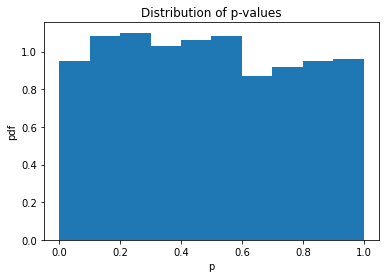

#### Speciation histograms:

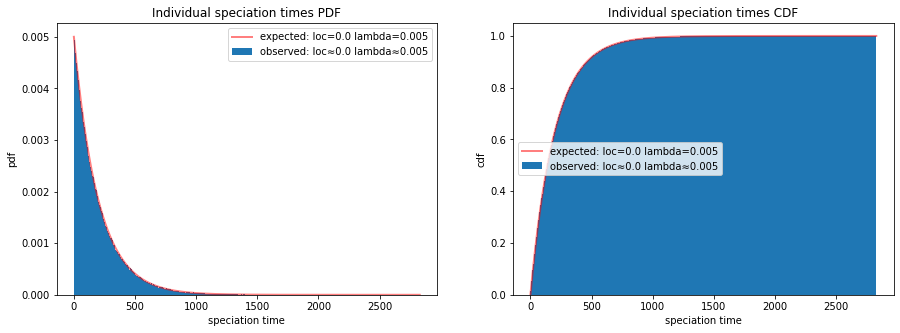

#### Parameters:
* seeds: [17386998298162677058  9432838068679716868 16876162577504916875
 13598336913132015822 13207930965558713104 12185658577002569909
 14918011134872518038  3914917040678467757  9255123800084633928
  7525208797292569637  2684809054187573501 13529032361780569844
  7374537580723458774   230268240436592723  8053484492676363832
  2780359704941423883 10679692217208119659 10275624115232772045
 15070167904624534981 14184502530601307268 14131131340094305391
 16557310054124125544  8490285754587293082 11750176678069961171
   291901092870941275  4631897906996262634  6046332357812632343
 15669732053967322297  3527644204389025525 18049042323842668394
 14175297421414384031   444560756706097792  8801218876324638169
  8415793639480001291 15798915489987958891  9789063023807230223
  6682012894940095713  1745801313429667763  7740914160891397962
  6602554429947616078  1986364662610147325  3378437774461304555
 12507270362788669365  5813371129689832616 15511918555362507528
  1264870478954915358 11733133615355769047 16112570921973802702
 13016339608118024675  9920501861228847333  1562214872914873767
   644226553681876702 16435132553208197316  4802006080040630155
  5318407865962609245  7763218334620019560 13960878786776497017
  7000889584402007939 16975300412477082841 16058505465878994032
  4205733759188739742  5992253545742402728  8077814454291007691
 17477365353869422453   193721655328890581 12184629451318487474
   963338023245332638 10105452072351600554 11958453960320152207
 13455339948097666182 16558758760906625724  5787275191088888103
  8315958998933662918  9347128206580078736  1821617904642211371
 12321303682750993055   272624598873431433  6328557440275935065
 10404182817493377783 14001082285244345748  3505081688373890202
 12343685802207847648  9178011807070225281  1011871695208790840
 14195426317189077844  5551270732952284454  3224739194646961444
  4228881795333554848  8056872162226205645  2563209209878575292
 13462712494258068690  3822137406493090244 14750485849017284248
 16302241437959986404 10739281522715827889 11287598117785650730
 11898789294666180670 13219907615752532684 15568140673391003383
 15983354870113644514 15741319173133791475  4044433049902692637
  1841918970535645772 16638820478002378909 14482146923493175469
  9562381314863023343 11086229702540163296 12511481432758459408
  4755737418566169447  8932273031973540544  9157725189370065059
 14575654495935357040 11380811725172340269  4363968951627194839
 17666133643049935917  6208990606695851527 14348085969742643174
 10941069999531976587  2231363383136406216  4313782242966467749
 14601628898372162366  7216540155052757195 14369545611664937936
 12083547271660363288 11093939897702462055  3752709573215111440
 14450104627292710531  6406527915007550334 11058950624308217596
  4218875452613122824  6836930248354562833  6300951955432848970
  8999429474602598929 10530921401287433457  6909311624455396644
   967517376461973410 11443347721887428159 18203729097592870165
  9641162191971010583    44513581306920368  2470946439740578353
  4599788669672466916  1727438288701990714   885114214815742964
 12998707383064528346  5657640901389994585 14979477182760447034
 16307317850577862609  8293572002866626923 11236778395483263874
  8995442338438417699 10740842985535690008  3028187847929468873
 14575955444713438298 13748947770527745450  1211655353170552410
  9861268383694305260  2442831227209143943 12171322859077088417
  6801019472331622983 16381480115284876441 15352741065817728176
  9751456833575993393  9295698782946793105  9979399137093187958
  9613800584273215923 11921293428351299587  8911506624254041238
 10897237416778771367  2744476810252370690 15103333668316500175
  5121042020960406094  7770884155451305255 16367243006495615058
 15515555941477491242  3273485149434063406  7942868769247319761
   771597361577643450 12901203037650081551  9858463950370553978
 12204741236816673233  8730825736328823408  9640437524916918025
 10626254906676787392 10749583309483954985 16799074855112138702
 17135762052369882868  6245174106124490358 17409751176316422566
 14938479233379291189 17176047354446275041 17960971269246496069
  7125407797064974971  5430667859933161302  1830523493563164161
  6886628404550658420  7831530792668949546 14993948916099456451
  5328544180721641860 17223180141240598729  2931171109332687962
  1497879955698038502  1038795687358679243  4290856518040825714
 14614575559704261346  2071629250615407970 12251191318942392703
  7338326110053882043  4052607684248548310 10346565959937781945
  1209298947736710770  1017831004730738864  4656602446909195284
 11533434917460882862 15976943998340997070  2772937112246998412
 17585907721941705366 10992897004283992351  5583836792587831487
 15362084928212316392 13025966535974238317 14422073873753142016
   776581721772627041 14110217365716194395 14390898055044720785
 13816745244572919787   634388812520156221 15951478757257065206
  8855032515037716587  3497492286761632780  3148202718659947163
 12855214980403591215  7976432904637262632 11256915441868273099
 13417611847824533120  6555397840704135554 16059359402806268438
  3366962905888663892  7936850468401373491   102179865218146006
 18036082117601118057 13414633897137778942 18194809408795037128
 15572632307589712088 18387468596336371900 12728869827417646443
  3462277386765735266 16278513850882357802 12805565716246465842
 13106916556680591290 18196352723028999204 17544885975503292412
  9110686418827726237  1198238951263353984 13083578162945623789
  9550380165018454900 15031764633503953906  9832773723278812469
 13723834400382896428  7235892466504627710 17807402204905490906
  4997288660210599980 10782721040650713895  8263571909561975970
  8539464085884937982 16917242603505068707 17472244051803889966
  4491828338618825356  2589125625716584909 11323911131005106971
  5150470100643297938 17767767172753560654     1761771095162725
 13244293601385274528 16793969067019312710 17346423992274704703
 18056872704608109382 10437358077333410161 14678990895796616733
  4407253792214129143   931662768337777526  9262818680999167186
 13254448551220839311   133539849535140685 17836384380517428817
 14293312074927278585  2922381837831257020  3655852210783258175
 10899899193803673808  5169602385091715584  2136282879960780441
  8293268787237429118 10967505121222996490 12058721175149037441
  1692039377711043767 15210724120610022858  3138921540384260183
 10906497048761951556  1721649231936444461 12111996613303849708
  1321098229366262884 11918383905618127400  5188990889362260146
  6270655503646318360 11301812335730890308  2731106541003063137
  7135157105139389787 10169524913437980178  4311114511020992295
 17653248128809521111 17009238138019835299  9050039889255698889
  3599972731285287299  3519659129115077458   934498531927141206
  9641258691559582402 17163269617954674796  2826148491111855378
 13305519226620203877   707512195512361576  4911794566591735509
 12150349782408612371 15819895594567055587  5859703796872323269
 14798151838221549833  1807213160930634761  1263833536864943764
 11049296332154503347 18054780158220338911  3256664300593670467
 13933893663808284865  8252703128090446025 12631275308711568764
  1691077007791537845 10412909244106433221  9987193519104647652
  7625030327607993918  1181584609315094805 18152165358081468955
 16606768365284215944 16930790281903637116 16638075419729914999
  2668529171374469547  4400787140648507578 12324069246364135616
 11663868476065566781  9613714348572023377   123525825533025670
 13718651006247685779 14179885136339195440  7984136334159992036
   413155655191757872 12353999319044034278  7323096206889508530
 15693427223693105431  8638440322192158965  9648368029688198185
  7844764042821138943 14551422407545407057 17771920900287886060
  8056695732716513681 16293905374903456795  8734218600616273280
  4860792758839017706  9483790348662379524 17930228838454415405
  7336289197409680021 11634457275397895888 13915898885582795787
    52497992642269444 12225519822080160424 17096442146277745347
  8781458599299036935 13166895551530723437 10090942467276166688
  1049716864963639559  4608949688410457398 17626323383862090351
   207349840368309740 14509988599892928931  4560216956054841917
 12066967279803099735  4961176710778926994  3321457670646200890
  6470978605153883676 14167966792670577778  5716235748514125999
 16671484216140787048 15517869042850266518 17740202751657628928
  2047249545149410160 10602534667259234855 10359371131108164144
 17190137399931133774  6010315608040492503  1396468295086221440
  3991809473736121210 11044988761385270486 14715501358645880110
  3742939987572147686 10240935878491356155 15996391602766811065
   100441493654563735  1630233579357914933 10280564178619931859
 10310696743262589262  3995166185935117637  2648707419113309455
 15463100975184600349 15037927211687236841  9116939063088583226
   449212233133821680  9414460498683555262 18081153247842717554
  5197735892994817368 14984073024446783551  4246130732553997257
  8085494220794194129  6459656392352484025 15252659684536319537
 13619261755191219400  3429646227840703153 17601146044124271917
 14765704336863616884  7235319551419245833 15072141676329215740
  8153919253084654901  3263101398563282731   918735234866133079
 16843815430419670303  9005737414296966794 10058413352940477259
 17480638747981297141  9374001660323393814 12364869629634504725
   499508784061034667  9199489315398145335  2805924545926361188
  8406414092683872602 12628086137521738644   309038309162103996
  3182183056316912186  7397362000788336967  8284514938524935623
  7196097117590678904 10267099027613398046  7987482101961297047
  5769864763414944102 13632678150625048758 17755730216967248469
  8326486374652384334  2932520198154612144 13690714904552945358
 16474906102775162252  8183828065299704851  5008009455188298887
 14909410172640168320  6686166748580216131  3852682997971856302
   890750724131000646  5184244895982715281 10376042840547563002
 15607280979455597907  5276800727872130033 15515878714317200732
  1609638203604219541  1371164181938400396  8029966368023904501
  2758690913142155276  2883503142075627564  6859618552188361798
  9625211812619739168  4970879898092899014 17422247328111413984
 16173196030073377861  7067930367305242881 16253232969936744652
  7233839671692710678  2466804448994527492  8601201654921961002
  1578117463556423905 10143048018556257010 17123634218476503138
  9187969804147211374 13709476797220643629  6644421657102188140
 13025060680476406378 16129659237182586150  5455662645360743563
  5162089223891728981  6964067251684009529  9172066121521901140
 16674383581491333621  6160062405645549440 11704482927965541617
   154225900760954621  6727190968731523665  2928521902859080346
  4741425810677916860 17240308490718014117 13827117525594610847
 11956629735749401589  3887833210932179003  9659503019849170545
 18186438694664370899  3440330189281945348  8455509388960262729
 18334867669512142480  6165945977169422222 14838880767870739388
  6617438208827192958  8043691812472553816  5843230594369364046
 16684532545808936673  3150524223153887571 16806496496477349343
 11926333708918515051 15171090211319457999 10183449278147843238
 12224834787500545472  7885351965979225767   647159926468575458
 13349928653387103928  4724162087413387060  3692682492355481171
  2009869700631948780 14072601051224245038  7283332472705658142
 13515591425653875579 14878119470648614386 15589836619782853506
 16689066256821166726  2648456828745829304  5534792277737521541
  8373419422820457428  2891361889842602298  5792419908831828841
  3143350295606167008 13821852537785705601 11814907757157984586
 15453147348587976545  2636284700846113389 16958165751603379972
 12162419594391590616 17395020605963788145 15575467341343037076
 11787840229726819581  2168818155906961762  3135837115213553279
   203463601200725510  5336659937652184546    62656902202179057
 11918005978463732290 15298709420444491198 12387484375326969317
  3171901834995380469 15196509040363312304  9872271173900287188
  9524250403616949201 13708496601258937564  5115710826039477102
 17794504335881970418  6923471431807200587   473231299346660377
  3240025647755847097   869697878403836583 14263375975770100634
 12414866897544407328  7936599288745567657    10127179606054739
  6314017156686581099  1109299173083431901  4935943489665782288
  5416095310644638967  7820632453934666459 12748398578435212582
 14082748168115372586  6247504441843257524 17570701430988523933
 15733640887333577970  4127001255268025999 10044001119678087705
  8136774371731632622 16437795036049607244 15682782825657042852
 17802202174589336775  3699746767396720625 13402651567589178438
  7716028053670175165  9762453912331817603 10788732618882345051
  1950915996717450266  9191085772814184116  5721672053896677977
  7915031481801579765  9881168824780697510 12156367329183719678
  3376252325497801396 18039150350683181471 17408839630863867237
  1038272935973364996 13000214575767586040 17332152728133008966
 12777825402761461678 15855830707857852823 16499714590801898779
  3798869979026070906  9810374558502575258   447861986336705059
  4055824258475089912  6330066837929276675  6485961112049420632
 15390864156345732309 10133784311802675934 16728014176892061906
  6749022695844416092  6550311036903144042  2164782538930060328
 13441670021799813189  2633195783699282787  9956004685557990507
  7217166616438026570  9720668963539752551  1184668084294257184
 17525654691861927658  1766220242729353171    84352599632569670
  9937119875650655730  4021913204091996857  5355636467440358920
 16585927290433409375  8093877106670813915 10429435149697730694
  2605730780448690390  4244849765617131708  6554976126935375683
  9447321844694321020  5011513141642037660  8451012444191707170
 10475456677766793906 12658978798362104955 15030374311408343895
  5195170641072060624 16579810940652379946 18274727149599811160
 13554742547357649848  6923696099528079018  1637888546218399665
 17298119427192191785  3337320356995902365  8480617501911597675
 16061530814317080540 10618168208881359423  5900263026619328773
 12506073473591745509 16412571872043527586  3078873287012681368
 12148876764944177694  6083229607360561421 10951945958477838711
 14791910525543969257 12713878473814170719  4873028810092996823
  7606378263869041505 14516406278344215920 12868140827199380460
 13045653557498617213 14271139841773939549  7330414210186342385
  3809261942149618935 10581342687677980378  6236991631114880413
 12380522434779386100  1551474452067052571 14593201975978549502
 17631808452961049789  3578229719630463855   843503347542765247
  3111187983380338719  1228289273383481804  2422694098152919752
  8280735409734749946 14777008092190444350 13935935369263176476
  2483786454546375018  4666008214109309308 18170751459241407333
  7929484670356449373 13765256156509706058  5501729448827369014
 14008411538425649153   689114605629543702  6323312647201509330
  2147293686365350388  6814595132115575226  8267644653395542583
  1323626701930292038  6385527942360658838   525228505670887164
  9872257643477500624  5163395662951114341  2490996658429181938
  8664968074701652046  4074633143860893010  3980235703516228468
 14614895334864912655  1946943817934168377  6886314275843290550
  8875606770861802913  8089391442456772131  3022516939499125829
 10986571226020983019 11861810412590784869  3754867088761635288
 15121790576092880031 15268276502306526124 14846004307702529880
 11748870526664347180 13852853886849315210  3226271572385796320
 13299533516387545372  9305390362690521869  8559640316885422246
 12865360308310364181 12902356843388657018 11954509024113847567
  2952803448798746611  9092010102628952057 12947203184659932617
 13578352485645449655  7094571257859101324  7293202581722460532
 11424014586744687231 17484243930872614388 11594943593793229722
  1081064268196664894  2443703886855299662  7738082731187771416
 17446026008275994597 12359728403878444248 12608615470668969271
 18346781145653990267  4298369668595187322 12546341484254322016
 12779758441910138173  2360588235022007735  3391394276716147191
  2491279079335565110 18204701740725996886  2806679638543674452
  8469132803950003743 12234559819905268844   100904394283894072
 14081083294641543916 17945071867742777125  8785866193856574323
 10809874285806234988 14136454070846353720 13457231228757398116
  3730955620484330723 12828233153504684914 18303317566644493341
 17453990686740714597  2692852086213581243  8692889649392949582
 16546890644689055373  9600632341683606653  2534126143138508442
  8047333619840970815 11312052564816189313 11659777107281974296
  1456452745822223724 15192022747842128798  5048247922224726719
 12846519917936796590  7316301198577027105   850349284925556625
  1486686361166275396 12648150122731717581  5619401714136804597
  3432076234017192794 14261046016533249930 15810801128551401907
 13236410186379827744 17624749648353982089 10628893474773023213
 15965610753217295766    94879508021539871  4327244708726997165
 16813868796334781046 14249792559084881199   128806088701360962
  1529065521037521428  3370154225571271673 16148449775441275983
  1115306606311580323  9672263547882577202  7811963809059565579
  2034899316961625840  7317582265273443431 14982417469041687207
 14876957324883891752  4903240552571283112   286048632889587738
  8199317365578926736  2754155999700376951 14997847441099139728
 14032366120366297482  6215329338698636079 14568194063706129350
  5755856038849476149  7398492956303526864 15294779777566940270
 12292269137395572997  9962909217906691708 16499648853014188454
 16157394674913573270  3592455089077011308  6385546354159971130
 15687221129346365072 10537885686075475645 14386291563741094501
  2659410195154852510 17267119712847138120 16949316107438551846
  6316557226296362783  3678710289358781865  7318620302343796932
  2558144846342427558  2365552329539460806    55650535219516961
 12320820381790042056  4218230540590012390  6858573101378100445
  5434579516721816910 18405702709147658752 11014444664235063113
 10498024695473273442 11384937383809625579  8142584816180004238
  3255467992538813400  8246729675144506775  5269285008896525386
  3613736903068575104  5451346395328992298  6187937276550105302
  8107196024474266235  9063647365980520011  2771814866002515644
 16377125738669637052  1725384133663614367 12481079399225613106
 11765303205482345877 16379718265594666815  5327942517969312015
  5172335603642115514  7155153838379196588   366914341856783993
 10178142519402783576 11582586842382366807 15675096736893289907
  1702549355167588162 10650737639725068047 17573887380969804249
  9761144012694632764 17847921489167685418 10096157917619659708
  4367729035965837405 17378763722383897978 13231084327430187488
  3247193051118317907 10173628607776355085 17497283661667409398
  4536586930140114557  5800654431040124499 11868934696228173494
 10901483637691658233  7743710732058957579 15122713613250241613
  4629293719059930973 18361207389731559370  8333526553136348671
  8856619293708048261  5142039038957672405  8137059832383409221
   283034085825890892   371063685609834540  1336513567553894197
 15262020593400024466   564167304864102290  1451882771422441086
 14577285725375361458 11433720112533272465 16357323912095434072
  9125915447764988767  7286424644144033906  8091488066526861196
 10871969718807925630 18018038290723545892  9573950131652807530
  4356247754860971480 11054834967078378205  2823271882102153411
 14949614108760348736 10157260409369687480   680995163827292018
 10866547260167648438  5754690573645809113  2906254506540004030
  6794981557455270263 15158319242745257823 13801860169868834842
  6392701130088188488 12877635410757133422 15258952709383612600
 18276405781577665145 10965686923367174538  9450858142352127033
  9352164021846106627 16705465845774939647  5435084538171450024
  9746098240691209221 17148780722357763772 10545070653964510423
 12885418355405601092  8699084321197326481 10606943927259350014
 14624873511875402977  8879538430812308640  3873653386167065924
 11941049176558839463  9879149368068332438 13087314757071608112
 16413918946935624149  1590223469191454998  9380221130702456365
  2937436683406793542  8191746754812907562 15634402814520551813
 14804249599623724847  7583201867001538455  3401524432652755641
 17065253807935681517  2402034152560450772 13568905984452433079
  1476528519665719120 16175812842880401851  3203812371918169696
  2040199490279087721 11665108785071471124 15358278471043407038
 14334994942704170323 18315379294627516095  3946829137877002798
 13265831650653126763 14694257692016780440  8657742752567990640
 14891535438995195041 15095921373446338863  5091542338345145723
 16575765789977920256  8456258397423160014   498469746870663661
 14700629115074452545  7488698705521681599  3777712018199277977
   743603126217040585 11624466435140449240 18026742465152363265
  7891672514299156595  7520397790006501003 14661706908028773916
  8985424078004790431 12966953175127198181  6729406024493884294
 13635423080047990526   101366448286671735  6326479518161478432
  6401621134911318052  4740819625730575965  6379761255956743327
  5611926216777164797  6511461750594981948 16717898925682052250
 15410472432459564266    10493333881238397  6133902986906495066
 14322254920561453937 12581455496941935716  3257328719980496923
 11356783672560198246 10769775694302827830 10330596063790942249
  3220094810206606813  1690154997931969734  1140396198038528883
  4138694886699237704  9551812858915301062 11115275362204230691
  8439824376471200735]

#### Configuration:
```rust
(speciation:0.01,seed:8439824376471200735,sample:0.001,algorithm:Gillespie(),scenario:AlmostInfinite(radius:500,sigma:0.0),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalSpeciation(output:"/dev/fd/2")])])
```

100%|██████████| 1000/1000 [08:56<00:00,  1.86it/s]


## <span style='color:green'>SkippingGillespie</span>

#### Fisher’s combined KS test:


* p-value: 0.49466968378043874
* statistic: 2000.1783842043064

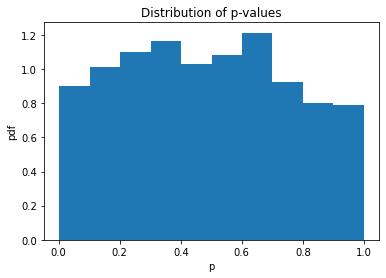

#### Speciation histograms:

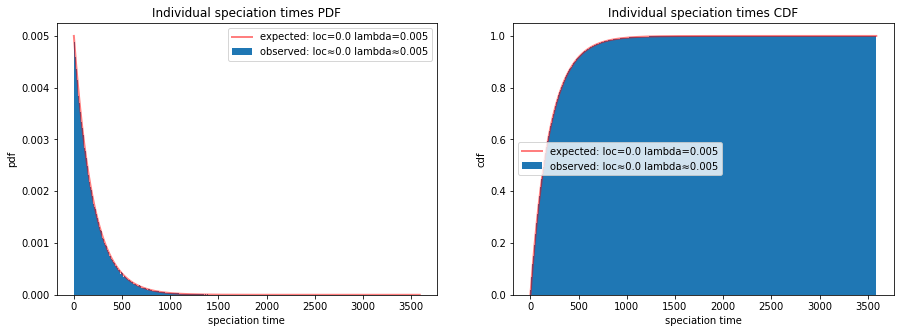

#### Parameters:
* seeds: [18421207905372237595  5475266158569345767  6090360431136891809
  5017878797246817626  4075702654800546933 15927106058200733168
 13379289796002854145  2851138290116749203 14950906819227949158
  1883448234251113702  3585526550233316825 16096090240595943818
 11842179903188131228 12312472982335553398  6321844463831949320
 11572342257346730953   529625548602960174 11638155067743213238
  8223863128036435703 11547523776432898551  2841778276082473257
 13559683205826772514 11615648596597031358 10913702777696890156
 12690498513097654645 12300877579969095883 17789661415895096527
  6685358107513379739  5090437567197319113 13051095992654113300
 14761282309309353312 11926828544025001604 12566384488585606447
 14845873857012599304  5478551583636187816  4828983725022386236
 17699655184188682840  2946104316205895996   534715105843543109
  1957121909926951217  3407428279387349298  9029063352850129372
 14074268910014147149  9084177151126700278 14850660720325569075
  7456874815646537077 14125538156095602636 18418055392026815665
  6834905843833511782 16737013456968390996  2468231800794840077
  1360503751574401111  9790065009792292963 10895158839265877400
  6122505216663263765 12577301525592574339  2055439960730388976
   740451087246245708 17865544241084677607  9102261381035269804
  5170608018366072980 12847227007164885958  1271688207665889406
 13582016125268830993  2578193025977695875  2329038825305936439
  1581659954390561903 15252614919135449758  6344469931001753369
  7125834067242695328 16119026293825726082  2623865617536121779
 15063438887534706131  8382874505406865655 18010925044552331829
 10372497613045245557  5531181087830634488  1648863347148492733
  8754928787697454562  4157209339144120505 15553452718811622953
 10850179237584813146  2202928891869640994  4493292696243044798
  9662667805964577807  4090158582607515976  9606380190713870417
   785605175563058580   309994788706785340   638449631967091854
  6675196454478438229 18238156566310246690  8041801357465778878
  5548053518485651368  8906699611171103844   517343667324516590
  5786757122924842873  5404355034010298786  6152713827505356474
  1570256447863577751 11986677824345235174 16500984173289389433
 10505231681931415764  4972824477830420791  9353774785818430203
  2453853236261846763  3454478228695425148  6462542496275716406
  6454305117225661546 11794293419008110648  6102922764891659524
 11982560750809925218 17111674455524724935  9935426753617176227
 16969875083932566782  7087116363553818836  4771755596363451875
 16329374108903249114  5805601946861236704 14871689958370947669
  1349777991506246396  4489160927865098078 16974377499913585368
  8149553973424404989 16715514631826437348 13735666909784384476
  7695940321238180930 12002136399926782356  8504340896830040283
 17059761147272776553 11091623279540055509  6554727106676569259
  4837277408741889770  3459736829674393520  7106537637118334612
  5458086693218839503 15217659984971446497 14046109586504575929
  8207191513354890069  6157063319868466500  3371582657345059249
  1184442841407907607  9416486816168935917  6672243425019670989
   980330921585491258 15518655742449305946  3620033403913640297
  2042244187652966619  8566186908918843372  6243152901859779365
 17505187200835392554  5709189029245499564 16057123217315926478
  8302400608144414709  1662767251325401991  7666813690507532558
  2186163119716704559  5055097690285394077  4171076144485610086
  3915637822142427228 10526235742157351956 17894905362219380903
  1430097803590164646   474703164144844702 14383087894235077533
  7594773409538326833  5897680948429810246  9411374628655303133
  1378165106929423572 17383079176111254463  7651315329635985186
 12302989988876443683  2809353588692298104 17090385921398846198
  2837907591797581742 14320819913725439157  6307458400899549786
 16452786975476762898  1016803475751323745  5738431285637846232
 12799381655371115050 12875311991944807261 12635732691221874797
  8704122095114376674  3884288810297761274  9024187913898306342
 14108078939888709163 15137309088212088246   711714690565961499
  2250956520611810081  1853176977335288331 10055514856422920655
  3224508360598306678  1569562661134031154 10391702144524270187
  2430420960795627265 11232415935096916725 10482727141945701429
  5577774377375437184 10512509871030485699 17996927125561472649
 18372559927134625283 11047359119599355096  9330136073601124182
 12113631365905904611 12068494052717239318  1085131508318381167
 14290563575320856063 16177206947498442312  3318477529468490120
 14160825642063736119 17966555582680270305  3259019393291214041
  2813799350948830090 10813082944222665362  8873044484913067638
  8153276842321460708 15543902001080799260  3363895378528421703
  8490484766222647870   606004572428952367  8726498872921980539
 18433163738717938714  2530229428307874590 12586450479541537176
  1743189174001025364  3806305490378328649 11288938082023245210
 18249744223897770380  2600993338309856903 15848912503138220045
  4763921210406084921  3958597302838432434  1930574187646100014
  9679174065705192158 12429242593806423218  5317586677346549528
  9652789258846825112  6340702702012934455 17043553647721124508
 14197955920248495090  2778004816895976555   299595871113730369
 11118278807876611746 12567709401593014061 12327778301473893577
  8405714236452342891 13488784881531937008  6632799468285689329
  3581423292132261769 16015681087514265764   469065696051525319
   701961938594126235 13819177936562054699 10739427641547466739
   309963796633665309 15225783732429641373 16705998034944265248
  3868204214165125882 11434142733103288896  5218994651165554276
  9674325657084074569  7735758138045699473  4172892162369701505
  2063450618551048432 16709181613732935180 16323843342168657504
 13883273143676579185  8289135788482233205  4919864952515307921
  5211379156604961595  8409866363419691275 13507755496102302654
 13158728724584844689  1818087309302465226 16469105186504710404
 17762121839178219633 13004523447951732429  7667090187700129129
 18379647069288322998  4685947802586244778 14060108007083244634
 11467523994962256278 14547344579732852372 12890530795806218471
  9385700743047988641   195763244069925222 15662857907094378672
 13239726819791214195  8882348442128877650 10347687568797055597
 13792427792158064436   406206906301414016 13122024409497583002
  7405486888793168322  6680416585855488739 10664667311009323097
  2962002932317720053   832456341349574199  9151432988736683711
 11868657242705460046  5557442843516508960  5330729261102919205
  4873731358792581882  8633876446940972541  3526065129312911338
 10514841778480058541  7941779641503124973 14469128933676410909
  3779049033086278920  1796506882807356271  8512586826416012971
  3664239011424871873    86241126312913473 13913849295571816524
 10354579983884325789  5593066413398628951 11942814948397457530
  6531594969241590977  9710991817099333896 14252199943328360040
  5241287309728630760  6993100567732832939  2283939390061526263
  6287380244358916574  1285292842111398842 16191173761070235512
 12980515432946713604 16809742641437614980    72206323959764776
  4384255740872242301  4146604422215604905 13539621827582433055
 16891451434523530696  7928679498062051970  1922870201778798817
 15058424026786712017   428187029226159491 13697035982929035105
 14542208504281698723 11693306787976211197 14719685413132880697
 15187130193785400501  8395033861378259385 13150099817610505718
  6832395366113870240  8922716058755024083  7126462907055934884
 13663771118781476332 12698986888532104938  9684323548572481926
 15404080709923201460  7048553979098966342 13153081654257840296
  2943501414013227576  5904207040687878375  7544554517041608883
  8896793372967423672 17158652727858508685  2226194698446931466
  9163619658768495180  4739358618330247828 18224454021195782268
   465050011887812301 11061382399411616560 17526197648535220113
  6520840893791893666  9968796310381199214 16517874534698365341
  5595187542969971004  3443349987264949396 12750505210723551318
  4365363822960282781 16523511339572919442  5841851311844139183
 11202865612946023763  7781131320965386598 13782375535312603777
 10344500762663179843  7796134274123460126  2771327913015872976
  9951690218002004871   627461154438108566  4715909566942347959
    24155695419763787  8022875809835434378 13299520402659499965
  3972770154844473491  8201224477585344455  6831678974267812110
  5156257773240084790 15295222428605797062  2139102910028439026
  9878248965889494622 12350737192474383787 18400899436930624382
 16208944554231043395  4621365679471803026  7525117091346270832
  1177202896228270671  3745428720754471947  2467914649150003156
 15809762635261636808  4604168082008550166  4218391153485819236
  5001285894946070019  7323082643833233863  1894116883082961560
 15117680099574193301 13898512148121627225 10090513424479970927
  1475570242342148425  1501425006495011280  3668213291260171977
  4941805053670429803  4006124970259307982  6503288311900997441
  7954258493430570775  7983319347090211555  6484597318881429916
  6593499172633599203 11841216574228299797 14017081728639067141
 15658769482005018216 11795854606240495320  2936439208765215227
 13425282155757810599  8477741627876149188  7095620865503375681
 14178485595179996615 15491100502260581843  2472045807843211387
  2824496456476483393 11153347793214410007  4823168230282928101
 17502006147937155071   603400601480409029  3283661952297463548
 14601485159135951945  1206380731973676561 10109965470914472438
  4527665574822239223 10925126069990563923  8066457833509374252
 16808501230229508961 13805385500847367237 16548176505427316499
 17100806889855114910 16514237898448270257 14069549885558937885
  1337371791233750770 17202496927353202196 13808086947057678996
  6931620291757679669   698759861191840002 16913993311924974965
  9707581490699404638  5240473380614808774   507181096594448621
  4242042304357901772  5441214265678705014  3111191336635352016
  3654450134669610275  5358562579238816079 12210966965090400061
  2886775177896111763 17305262938876092255  1797214756655055238
  1371361561283645248  6503794972277184764  7916078715494763994
 15616224518173163191  4368625903897856428 11185482311914166028
 10716573953815857462 15432001878344951026  7179092454695892894
 10128258574290981454  4535776508080954490 14050791738201482877
 10750839552157405323 17948042401756729131 14265077146346490793
 18121009516088462109  5088429419784539263 12728910716195321838
  9833783110450441802 11681991227988048079  8839096587451038829
  8449702091636347217  1113450309631269857   592050942041788038
 15023514927323042810 15157694890228969203  5295267792399434381
  4270689072050442479 14639442980398080816  8605905186751019439
 18118283486976630309 16303479595606722725 15550687852078252427
  8859733795914822829  2865651238264395163 15607707711645192592
  2241256633023520491 11168386332304073144  2996125367529237523
  9436410227357295962  4378416508265234025 16989152328165549932
  8454297693043197089 12609150812691047714 14652671825426945863
 10742442360718723178 15770993652607143401   731958842346370389
 12353641226636446340 12733223358694628005  5983597418850558425
   439273336939778754 12567331789462544787  7321556491807927974
  7952579247666092781 10456436114949523197  3496287341211295364
  5536318247230845844 11323243215734734125 10804162007609063571
  3805854506975470130  8602561850478152072 12572280323237839141
 17948183015221779615 11528671077548859938  3983521047718745677
   338419183990854423 13068311162414292184 11372764121347966604
  9291953573558251379 11253732864993412201 14201309540284687901
 16334574529625346173 17410163019592809298  6250081604015036888
 10176063360808010217  2026838451957908207  3411367774492499135
   959918883614290344   161093489216152026  7974219402299189254
 11131294175408033570  6769218713813019574 17087679728269090618
  7967625499755078542  5045564352034618405  4287383318060927694
   701665355776891642  9466005195365731913 15033590311499864049
 11208905802181022071   944559127144101374  8250706824752842162
 11405322244658289341  4219846453077442668   343059968818839880
 18111080606121374676  2823943553793621888 13041140502039229852
  7694210842944707986  5781656164453989678  7347900261589701537
  8836272952558119757 16425412852764333886 15524561834282003709
 11962903960330898925  8578896875042370225   377398624399478208
 17802280241960102280 11696014651466754262 15393750484394900636
  3152226909656339587 16206185010768745021  4241235962743098173
 15323888812728293556  8562363114807820664  7802814388154715671
 18262638154443523454  5169374283684126278  8932254601931860511
  9338624343461462813  5175365357371174957 10538787719426396272
 14744308507044114423  1818406601573796717  2869313342797554675
  4167807954120543600 12299813397077898524 10548003907899304903
  8791740401352272507   583967810576913631 10241135619667720129
  7625642541331326112  7678347998669959547  2053299544437507487
  6411488678054762355 18125074561611199155  4353640048073633763
  2466019899801199338  6632625837631124079  3310699035743064958
 12184168507015089401  7568560621046053996 14896128034651808102
  7094143139358313226  1142739288489964070 16519865322057195191
  3324607782464484534 17957757451999866433 12591125950643399000
 15776671111536981598  4556291060935409992  6335308254242877198
  5477864191604229783  7755490759367618254 13814418304462161222
  4463693064339658354  3118818011519822252  6894382842129244520
  1916566777311722483 10867221541470714445 18020152642159505658
  6017315280144649013  9847008366690155585  9949231089512511155
 11208605971034562326 11915267331033910121 10080077147736593555
 15766709196574431140 15665591210156414136 17837838225747388815
 16973050607472772921 12305711382012695474  1659881936643367471
 17358821114619729784  4212025373899655379 16003665142447376033
 17782277918080289239  5074489026500765866 14861629291684651441
 11722142622280671585  7177883272924743660  9237177156624068212
 14712677358295440672  3579157944462438235 12537612712785605360
  9687280045544205066 15206394531170485706  7817089959706794556
  6739066897518041616  4724220887577428577 17904102157050890984
 14271226873032681615 15078351584577348178   568554868284285641
  8928752272475272225 10333489822158461251  2863923468982223183
 12091273218092443226  3111126274418933056 14583601041830760966
 15676307289927051364  2493175432551516625 10296080668398502751
 14438866964630471494  6932988783124143943 10738980400604266634
 17937989496180824210  6011803358199395498 11702342023534229287
  1330755574417006836  6603335328732344383  3011911500538805804
  3237088779987086266 13800075593470422041 16872922322691473925
  7376556369514603205  4630331034315753493 17834177980344932349
  7662662541833805899 14725035939528081146  1629242066827196474
 11384349720302677308  4085956655043782336 16539627017442394053
 11684836908869901728   411890555669716113  8870830762692364746
 12763445780978739709 10001867554916124770  7753695303820063954
  3466019434725184979  9985793179672519362 11892610590278814460
  8554762720794287527  8568910272541278493 18052017805136999290
  7907556687476228191 13299731041879077838 17276378741908878806
 14827337811817200063 16817221473767155468 10326766074313443765
 14710167437394758730 15822533421257747716  8943560683155498400
 12908849315587025823  8295937357182051165 14437419406333896021
 14230672894154364367  5395272652919999773  8374372109480377124
 15157896957871706999 18004561552549552359   393989474367495211
 10576063097703472117 13605132597961198103  3749171362400301028
 13507222224492280033 15578711274795145582 14274370575275251059
 11697288216297902966 12580255167117768201 16487165703112989838
 12286449731556808262 12910732707869315525  5555911180356385620
  4839583365194523751  2782663944725196335  5173351543554056393
  6345024405238067777  7332981122554141394 10937661280707406566
 10902786999902165400 10624054913123712928   900393135939708068
  2720774487120011186  3217287850201120581 13355615780927153942
  3658150688760790941 14905905098027473908 17460972844954911741
  2080544795661787439   268411462702647161 18358863187462321318
  3062891963092954950  8264719585488500962  2993865193950218271
  9214422821940759187 13202863962415204693 14343575674965363057
  6448036260194931850 15921567918566417572 14142441079934407166
 14237903962335616735  4182109616734135905  2473150692028278206
   896141162131716949  7004078521349728941  1233155990849594515
   574056265509824013  7734622601910439998  6624971220519344214
 15877482300838632899  7859299112364109499  9517941769298594194
 18123026392227799584 16470693655540121595  4833391835561818614
  4766861925976680403 11366604672404068691 10930137006511411371
  7470402933690967932  6784246373984938647  5434173555077081326
  7331752319825161465   503693423992525132  9062938599747124629
 15859428173723971584  5046088472454695552  3633555652396846371
 16427278027308375434 18425426856151621298  5873489442914529443
 18238829384602386755 14251535336509668463 16131461888193542911
 12627416213080917105  8862278471813975818  7009121743796028029
  3754059075063772929 12013483457654078793  7866587805713784404
  4546127575670136732 14475185178761939128 11352238952545174999
  8262200334414249069  3492810055353619961  8839264483295887246
 17661104820520876003  2824226493873605958  3858081954844528811
  4405991863378844066 14952577346682253610 17256570263965453536
 16917503914977422022  3139705270979182135  9923503834723188206
  2834242016847278561 16159884928472480118  3836575341466065434
 15550726500210243146 15845329170209306424 10585330861889999604
  7161483538888364721  9391180620110875404  5010070596543720800
 13199422623583788230  5846347274201725827  7185411630707549869
 15080299412266434169  1604198628719050788 14405068577030513765
 11330157969282373833   453479863141296656 12576991701587223349
  9497006535136843460 18288859633135714865  6150937663869784222
  2580716357446658863 17614956788757361312 16197774459987202384
  6724247292254290670  2566713296886321153 10467844322810645558
  2381941307038514407  4444964272413982735 11734841615122607004
  6451655754600863930   733105122063340105  7447922568415851319
   863047739087971176  3964372296746207057  2021823199657853935
  1836681497898175874  6050272047564154358 16278486181884324848
 11470888467617883210  1568555975620192707  6447203888720131867
  8326666163730750826 11740375988035596222  3652603927792321996
  7232180612236134850 13310965219359159410  4860826623919993197
  5418509087326113468  5849997720759377163 13020888490480499937
  6799887089199768515 13559915603525525435  8830958845504186515
  6142895143266668108  1880967324943879884 16158178002457817628
  5736573779968763207 12543653678425343011 10674099842898064938
   665997530025379105 17979947173998194549   749502163575681538
 10893616372481605855  3318179823486505136  5474317568580154950
 12025069860255445805 16029063260699755053  7990431825048541701
 11017077871203656657  7212958005084721088 18103478247060280118
  8998420870270589538 16420022838737708932 13094334692408327558
  2249177186322823256  8426375781394084774  8313862671494120312
  3894297076853547439  9477627558243676956 11945296743283493234
  3556237489338216824 17219877806090682961  7716251066517473950
 11812125495753033675 12095305518555726935  8121567532361445156
  2679525557782909387  7644441446374643682  6630327242133491608
  4003949321384437051 18372103442613066642  1422881449924586565
  6746551988707970012 14028818060110011931  2284511378708400964
  2985660944669268131 10000306984117403886 11831631957211549862
 13291556811231251712  5956464665243656390 16041948141289113269
 17102970881267495126 18353352075026846046 12832223627118203015
  8255253673243475410 14137977494101527743  8665082032134553923
  9645333039616621893   961055543411324205  9348437130641362169
 13165388375519294676  6248151406485353067  6640520759969409690
  8455868497410354990  9354332768307930078 11879957038945888781
  8539404059997816293  9804943124876971839   137028972771981931
  1729235413094314914 14527896943015104024  9847392767968468138
 13443551486981647284 13772863219248732306 13651973775373102447
 14848481033652866322 13544152152105312074  7264523211101447262
  3037565870596191959 12270422669375062311  2526761121061357759
  9923835977571793318  5237913079804140531  3128276551743775277
  8324427092741776988 14897047043058265039 10288197353485852803
  4189866012020170896  4050826139786995468 11560192436822793820
  5854538203247527106 11665424361631397237 15164582716428681011
  2196511868565641044 17215732875366671508 17474896857557457972
 15249770763590773134  6580259898377248514  6222695372072932680
 14592951258636960074  2836681403318722257  7378154688899195914
  4840592877841795197 13511846999229777976  9448491682766291868
  1862912184660698813 17253948465536863661 10840139630106551464
   865044773945916732 17512613512763056652  9553588728956681573
  3834797061540550363   460424467237260901  7115944541941903075
  2221340707741236688  1567115306775349636 10412925248734684605
 17006330149510367741 14656345252726034113  8660508294657264038
  7572896159675340502  4606200415132079432 16235922022055779726
  7982985495427593681  5107702870014191052 13085281517919145839
 15878156979260664253  6805694507630621522 16923811974136293607
 10489536966670806178  7299888008139298134  7046134839729847634
  8740532647351033738]

#### Configuration:
```rust
(speciation:0.01,seed:8740532647351033738,sample:0.001,algorithm:SkippingGillespie(),scenario:AlmostInfinite(radius:500,sigma:0.0),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalSpeciation(output:"/dev/fd/2")])])
```

100%|██████████| 1000/1000 [11:22<00:00,  1.46it/s]


## <span style='color:green'>Independent</span>

#### Fisher’s combined KS test:


* p-value: 0.39960350605739553
* statistic: 2015.4614029966963

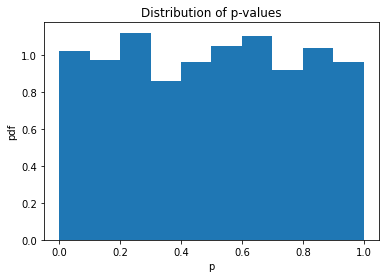

#### Speciation histograms:

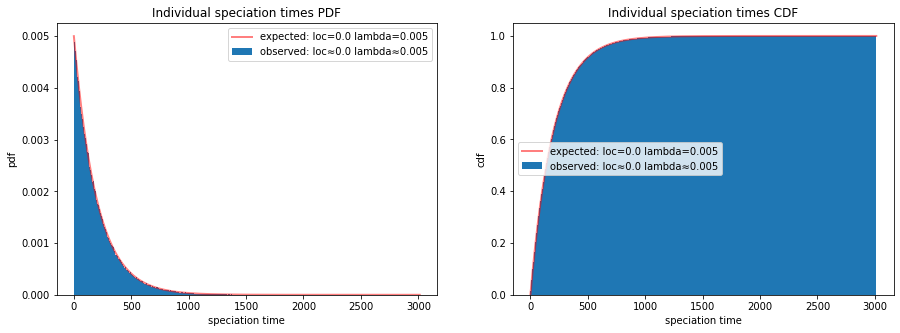

#### Parameters:
* seeds: [ 5328398264985738113  8659093190771780296  2326680940532865296
  9913255662166813198  4357841446332564634 13724255373412233143
 11174274789581042000  3277657546385469163  1407250338838542739
 11692324541788550917 13786469387546173386 14852585981412543096
 16400352728026208892  2426199510745265992  6708861942867087354
  7913681169148047854  2117101016197337102 18062020561040872757
 13083289331188494009  4604022886953564251  5527996441283462171
 18285771833027933883  4124441385509183244  4773782422430080945
   259748009595449309 15856076812159374202   917211126871026595
  8042188496015958800 11704614484400855143  7574055035055109354
  8448725941782929758 12875215385445070216  5233856818052257109
  8766640320848008735 11821959996876788549 14728556616770509887
  9546016344750059045  7186978827859322470 10158726594464880193
  1809905335631522178  9470727059354617578  2091689683939499646
 12037108108438743451 12733108251098775861  5458939800219834543
 12646262493116126889 10457926162337213275  1744539126380316577
  6460203454048928811 11088523665559476237  2315883541228634593
  2936670451265139818 17771914805687355829 11209491960502062664
 14081069217596550342  2228830947331229137  6664326390343191349
  7272084916650233599 10983572837193120316 16637731387758248479
 16297896123826236160 16831019869295657859 17795753791984486119
  2628738884446408572 17475130614034428715  3817615533938697391
  8865784079878529761  5611623726527685358 14216752683919788621
  6103816236346503632  5631491011822204710 13152438040801788424
 13361767051381404141  5587265723173201026 17450764823699943240
 16700606594593925276  8571120091055532270  4095625573526699794
  7468954326638777116 12991989933669484641 16899241782748429152
 16067402644070785963  2500226099906430549  8689472120444868808
 18045266570897824013 17381128765472421483 14714244372727587419
  5893637118118075211 13132930405467984004   285154985891004136
  8822079520931652620 14332435949356855105 10182988368943680869
  7833356438499551219 11614316301166245923  5264939870167085614
  5659388399464251989 14827451154567177088 12384670119540828726
  8513851954108081046  4582640571063795103  1475620859956043619
  1969961703517032121 10114123208852028480  3078746738740180491
 15799409680319548473  2356124703481672421   494476949899927210
 18402441648054505422  8760327049458319171 11035328048140414881
  7251079705247608691 15215212503393339671 12277382664949109692
  5670119483256062738 12222954175079642642  3790972310561447786
 11723819510481249452  7713759120968710155 11038057121912255707
  9944497241079008473  8710206319112845338 16945706291506805280
 10387325012610496881  6134697135662718074 16001126214067072752
 17323080248333236167 13847643084852338636 14740124018154198826
  3256750904670870290  1297316014625146430  1955505280428863277
 11032035463241572322  5517850422980985011 16256840402190485202
  9779436477793239978  4654469692449655579  7482955698606794952
 14280503609184850241  6555648960846401481 16112599836772568273
  2851918113124478439 11622642789917900484 12611888091876140576
 14744128996359350484  8511749522114724588  9782622213804703212
 14054672018528386886  9336274396491330158 12629265675506281818
  7912421307151899291 13055447492619833636  1931843900436731508
 14752709464745076276 12607539956516308757 18177114970259029415
  3568271993110032123  7848611484142295448 13916674699851818649
  9154046278834957015  1472095904829568171 11177503718212156213
 16121401153796694319 11731747576939732520  7821917464483219690
  2485189247734388741  2855713513887562048  7729049039403980049
  2099736441438960372 13318754410075085833 15141452896356086683
 14428654356536903204 14166757853272806042  9317957523685978956
   199883100893044669  2103137586624882710 15768435898184121441
 16722794271727453599  2696805317734580219  1069706592700049185
  2881779366293847038  4246299525029804050 13726670151259057272
  6960774305055173705  2936719988455847867 15791120736052123693
  4496907872937494354  9090405468813800421  1123381045736329031
 12558007065802498592    32841127804727616  7344782093778085804
   853519235368640841  6254244039209828644  6788620091497264533
  3652133279429731291  7318772158119616181 14699660785590242426
    33103039753065917   104972161469820085  4291675442643217881
 13909086828142914266 15026692750493273080  5603986454325840780
  7952274673096485516 15595685456649397111 15346463844877924715
 11868691394431997668 10989639307466211738 14353881910759107586
 14532202203379591488  1257669163362865947 13666643142566239437
  4518113472239777347 13308531853974501248 14683264807828966139
  3588739222678241558 17173062849507811083 14827721745964451095
 14523632414108126652  5824844126174250668 10637621899706905871
 15376075782803898381  3544284006351767874 11950842859330871171
  9431769676777002187  2120574456401190015 18411324456199269976
  9668443373444413721  7113313988713052999  9551593632454272417
 18198549510906696074 16917466307592313086 17006722991207605725
  1845672632138034960 12751141776145146427 16411573822197755081
 13263080460581997795  5188953444783779506 11954025506250702901
  1466523657363331716 18139228662247407114 15293788730102052842
 14701789574444293751  6415473125896546743  3497121344602115061
 12632976624968439588 11044051926497297699 10899157164642176305
 11186504979480649404  8140785957017713190 13496996143910396239
  9660168563877581587  6071889671892704577  1551980889907970622
  6318517501799333778 18445964278081626381  2306854340043023451
  8962162137864796967  7228859511609447080  7403243198148738799
  5411672239748008680 13169872379971772718 11953113174045244865
  7111354965932261747  9256933373398213555 10973851939398833002
  1854059063394218133  8726406145668471198  3113763587957031640
 15175602535400287849 15152704256654363718 15415232795552239702
 10782421175273277279  5855789626467953859 11541821118049887479
  8290779856875255175  8040581032252862369 15298914660376088244
  4699041861897827497 16486616020955177280  6192273131720834025
  5804363534131185433  5391313869948779599   800557900968209375
 16935741373696610269  6831519363425149040 18121396834557495664
  3353577338220784146  5110714249665805964 15849762824483748973
 11721920324267986512 12459350718417117323 11559053741399530657
  1729512306388116697 13090938606411819051  3296258393282007584
  7804100624533965687  8685837902800534899 13295614323951209863
  2596883414911105280  1541386912312169621 15993366922706132897
  8688773872586657382 12726299900964155911 10218465300566106300
 15582772826667064990  8723862815407983482  4259368050220285807
 14375633265330154920 10941856757741636356 16336268955983486710
 14996914391220951645 16700444260558086847 12697556447820567496
 10804974071638177365 11047561198306488600  5138990737357220684
  8829056000908653164  5336667566990194414  3729896520011466246
 13331143792493791323  3727573058848243614  6988753352927170502
   819336753888907491   148945037819987489  4489508499676262723
 13784002263624348488  8806777550726224658 17000749557380350054
  1877152958353752669 13962172962829768583 18076532240423334265
  2228842173397851517  1521772518573420335 14066987740787425596
  6187174427869844876  9720953448489147365  9652123507800053704
  7699943888493905101 14794240691070427663 16620269671728948603
  6373350424134703844 15801436268929793364 12881516834098280668
  5749740147686229407  8329838272983624586  8568266731559919917
 11839549778894456278  2899756240357601400  2643091411876074265
 13052936253083830076  6327015235167049973  6495278883199287435
  5199840055911782797  8305694441702327008  8802017810355193134
  4310105775379813758 11795378620992269037  4558278020665636297
  6519103425547717794  1338025187803733158  9897359734356978785
  3181562298400577856 13386382362562749267  5054412685565935162
 16163097378674752756 16587867138037218881 10889961818367215625
  6228943829473229684 13825457885672539060 11409208351197101911
  1771805703307284696  1968286353242798769  1925963753408962367
  2569103936054742074 15469121892688355009 14063746000351601383
  2872229436895809690 10186833391516136901 14320270742407219960
  7601703782055089722 17560270043437577074  4901945514575839453
  7774696815094824219  5589390821250036850 13920041766883297799
  1176952927691542937 17476148590094108087  9152893930070795449
 12519947295803977213  8846498862271463964  8069751312341926094
 16753207563034523007 14372451302999074720 14814343216348082276
  2454237639728767332  4316673380197098759 17204610677257101843
 17635630316088976507   401030543893306949 17430631155935639022
 18216103744177177086  1611266821535164236 16673615540078910899
 15179599564718796757 11019678477279074537 17034961242618820866
 18130675636752335456  6483860711034294696  9285876689189914917
   710297870520230000 17395799649640530863 14634731243629194813
 13148708066200612312 17662693934885745191  4298148028876800628
 15717638526358546812  6968129562633205913  3251631452955773514
  9818609061362305858 15514949652856041886   650104515473597212
  7422551114860427179  1647761640334804787  3562655609273407380
  7791360467191288101  3882673595665998158 17795879330773868483
   642796776694086452  9060082940181533842 14023271918689936391
   745146258474588933 10032837154511244351 15582951875364365222
  5764551682276726507  7508449368877789230 13197473019649212945
  6792096748104955915  9750201563312698695  6228857861588813298
  3547247394195605904 12826079270463415455   745759906762960625
  3347555639130260774 14641582171856348502  9565515842054618935
  9901134925590965073 18017940040091953821 15705473369465774038
  6882946382703006645  8581721723308146979  3714209645607191293
  3463498589178061369 17551803941339865272 17379006606410924470
  5421842131853361685  7253243411676851418 11327533527719892474
  2228647699887301647 14226836349707949064  9937044114804569682
 17387335081964567015 18120808667024997386 15761548473963482282
  3201388194534271115  1965061982111611083   136870070698689516
 15011021587207201880 10474961337572042613 14002681506894656539
  2960931526746329589  3113402407353996793  4352275734276839391
  3328109784462943767  1897741135570896658  5301785699935483905
  8552142796140341920 10597213231413471906 12722029200310074989
 10405855376078541896 14102047014477159408 12215476783091477222
  4589015650057249307 12286275607618103468 11152112580596822645
  6033506981995591023  3503101598282680508 17884478104904650145
 12850189515082542854  1208246734031748258 17844738088413171012
  5255891710061187719  8668764819322606292 16674473350231570721
  3011002884734748765 14278365719384246279  3802145721516469203
 12934524349114778585 15849750917417095244 11752748577652628360
  2865658990358935526 16816075397964117619  1787761035775527633
 10826841946774643682 14393816001584574802  8045112580891651756
 15843740387403276875 15995872342987527269   130682038593080215
  6435311662353360416  3708456409615524809 17567199086675549710
 14671759937603512192 13435293849772640501  1639719068618148843
  6193156009544416523 11351784249914847676   112551589756465776
  8216954100980232041 15518502800084185782 16627293782434610060
  8864785588479343242  3174799806963111271  6439863302722816281
 10412749243720962246  5718460573330114860 15551412429931425080
 10531825174542349528  2841873824162779407  1821735714497316418
  1949798767430004536 16274176226270262836 17215061091890966999
 11719514287470495112  1269395852939243636 15090790427104984750
  4301049839695878632 16673592491061570521 14382903104285721954
  3385099495051975421 17210008091992946624 18328576504930123508
  6105940388915127762  6592411172706835839 11860064173656079494
 12536932779627244156  7849916642518196629 13200612556194420628
 13869615016047563022  4947038920297861187  3295906613557677208
 14862793127032374610  9123580478791916678 18414938806978866438
 13758150711295036819  3212106895340476436  8666870588749928288
 13292701984040712686 12044352427573857900  1260493902638061356
  3360544488432660535 16492933155893260512 13382163243437037666
  4270262791444278502 16239757397226950736 16509715127760805360
 11926605082738142910 10323419136989083438 17821167067639896812
   789163963367002595 15441362200658300354  4477640631456879222
  4748763727656949640 13193224466156461119 16411516405892183894
   481068761658230342  8148414960158834061  6123103802140194653
 12569096628072848491 13646395633744023819  7735323893926610332
 10976872202587680016  9762834494246484381  7557230435538133134
  7125316413482288436  5809297571843235879  2122304801301159507
 17223855724547023181  8440352565152509432 17682809910071799793
  9050907481962374835  7386531301408914054 13186094452002120890
 12177806199102495877 15942370172517395228  7916455759030795559
  5145903096190156171 13071624041366122401 14300707340282893932
  5181110559323965448  7531641246491335612 18308061744340692327
 14422694201527120281 10424079804962047246  6881954007542556726
 11353919999556358236  7887017527211864679  5734379106651106651
 14697012054189061122  3833936965805281955  9719410998965612792
 15727639676205025756  5851101147004710995 14476615364903517989
 16696765461487497379 13967856486609552963  3016035604165064094
  7188409678156864863 16315684321214201088   454988544837400813
  5499598008004503380 17319619503892546214  6336114415849637863
  8443443744994548801 13222709306931717457 10922982591879092239
  2906366557426375875 14963227154072829454 15953761716068177842
  9894499854571897345 11702361774104062690 10409671921519140136
  7499327949518985221  6186339927767477620  8193600813796464190
  7575476752971500929  9980519746210990441 10223666860788684232
 17212696515440169943 17842938764658974477  7388854392105678151
 17264699159881270597 13811178631180681571  8898532400709324943
  6789450435109664680  7013932367414495665 12180082040213533784
 10860777673697921970 10384704373922450376 18429070475525785982
 15530575320616907785  9140160083494902128 11326683307006631576
  3435510853125213841  7014579695362940456 13081017481323300701
 11199911056841751503 17087707736453092568 13749674720773189020
 18189085466439290817  3825857868286595513  1980182606854828852
  4439329147807784923  1615210241686431486  6055582198768470794
  9454162343990140172  7473966909715597702   806706050177996099
  5390063749434482294  3043270707282909303 18118437154082344896
 12184708663664034399  9270624844554093062 13853691498454446348
 13780155543249822714  2507715991842210466 14820887771727600956
  7524028569124404830 18208724101129323903  9470937839583225019
 17463140072363545727  6550359751925555639 12263051752491223730
  5290004979273682700  9198324620885927411  7844690476610519122
  9839088193165748539 10319322897292494515  3843399056304963615
  4610619818620217956 10979729690293425175  6330583463017606814
   294935657637600933 13986846379765326468  4795155542004755406
 13458763570436657807  4885795007310164175  9207290037866489605
  1910070922047785776  4322210770950116790  2624784841120040918
  2670665479336833908 17882109914056775156  3821200411378803895
 15089921215966272879 10733028181579227913  2298554623238981401
 12736612956528123408  7465763473960922806  3371285188144957063
 10366300241084146240 11406864167743275302  4265981740563064117
 17488653113323993497  9720730245313440746 16279922353782372562
 10100368625421483930  9243248735902316908 17402148123777689962
  7848526348417763352  7131479568566047442 15894548980781935982
 15853744040532460165  1887045810234405413 11854827624174868633
  6392007932863305452 11929421633483915888 10506076049370249367
 12705498993150062805  1161748430610090510  9037422976424272430
  5797272222666875609   939066788633083940  5892317851884787154
 15313301163375198143  5672429520763042291  9750433883905658134
  8985311106913512486  2966117064204216396  2321863725848033758
  5970041933732516582 12818249676098244812  7838926453447527526
 17002581796220362343  1365395374838274425 18210540799307757494
  3823638400698867306  5820730980771758627 11781715606467497851
   947468510744304123 16655227136724587207 12305889185242737327
  8596945289534828426 13420988463025435155 11640378651192949022
 15092872832001453086  1816042318163791712 13343193569444717169
 15336872376663908461  2933296034313813981 11393605667669574760
  9894261637382583674  6279915902775095756 14399370155720065439
   886819566493688976    18425978297790383 16171239647566850308
  3300619192536139100  4649317471503761073 14630114593706332518
  1612773797792323257 16467754500289391223  4995950073387340490
 10288180031869653084  6750279648325584067  8893310859723760972
 14891125897426605007  5914673406310435442  1325977288441851070
  5861674896414593863  8755918818488086005  1943533676854618946
  8424366491037032511  3063080734596047272 13401245220159388544
  3381546323140512731 14671845681601234602  6625734082211341817
 13067228910410919140 12171379807841522622  3969281927559050632
 15243850328126476811 14421116501605563761 15474559861784318146
 15544228886429865492 10780371484924683790  6279822090001281079
   828293108521776332 16688528862770951939 12376538430431399530
 12165146472836111395   534342884037391536   242005612228198041
 16722839753602253757    46519057787064314  8867986941013862265
 16241792626300545686  2061587290740110149  4698547949565777543
 15180499384420664519 10242875835360158422 12612895547863363014
  2457826232779166902  2836867944721081152  3093432445580498744
  6020616497970955690  9449645701795174115  4570635253203700151
  9634226136752250402  9328096381181226495   268833447335195764
  4909696748605825731 18134551303338953431  6564806279383976165
 15008466694811660403 16434849798987821460  2922370805085762636
 17915925969233907495  7789330737035718760 14125099466685709673
 17190389543811181607 17822005680922770656 13363194825531589688
 17566008737695953384  7783684250307531980  2245483739241659037
 15893918129962886115 16330485511086656988  5864755142371769413
  8107931204689731299 15685177175719078557 17009336448414519453
 16374885903031051677  8772197700176759377  3559595412947655610
 17998015675641422834  3095411819143793300  3868507497144310811
  1275706196678038432 13429747340993633356  5590782913800272244
  6079297982001769210 15086048781136826345 14821075691293758971
  9804742149774731735   691944975553081668  3713492553751359471
   894901964369721791 11282290764421253558 14353526026461335834
 10787067625876747281   570851547402634924 18186458180694683624
  3384679980982554812  3932315756178698764  3364731205465011962
 15156042637451352896  8054030174513373990  4899279599756896588
 11761190826988701670 16324909103627217331  7080963178961698399
  3338655049981340046  3203046475090595064  2261622843245033003
 11072535560022621689  7703686847863686220  4592874611760358193
  8019085635141798176 15685476342551088343 13127286960349311217
  7863175372222502351 15256267326926498546  1305043229441297788
  9638928860647261143 11895993226359592009 14833871995441990555
 14335465148952778771 18039598198831968044  5745923610250412019
 17372859733667526070  7042541080372926337  2841950163601689389
 15552182264550955315  3385255613465038820  6023111345939350720
  4240344748050543625 17552047178640947160  7629335421053878633
 17963620027776877756 16360975767310861496 17655925295029286496
 15347943841059916435  9845674988462964518 14610538715832525201
  4783797475880943658 16153031762223711106  4748769861674923091
  7013094260526100781  2969046546669205023  9024320850167154632
 16365618153525355169  2951061918060896589 14444597179841368651
 12189169758477937959  3323486105053197831 12016311475939159208
  4716533497168065968  5609129474840320232 10229246439144057403
  5626087396957135849  7229740863308089575  3410459691996227796
 14663205661395263337  7791288312158324280  4609456356919890034
  3546157000129896869 17190926458866346685  3575235233284775239
 10791217303867332236  5176675292970430029  4457692019560919015
  7277053521990513811 12073917210606004828  5530354355848737663
 15133891539315575365  5638255648799283198 15969023624141975852
 15576811741338560750 10503781849246060300 15460558863166295911
   135863055807739110 14812337403855551326 13696396270433909976
 11642507881921749059  6336966524006524529 11716775506969755131
 15783824735204629982   895807780371816961 16370139961317389673
 11788784894165471026  9028963703268648961 10506892571509793501
  4802751499882024270  5550856187691962606  6220921763252680162
 11054068167693368421   395261782735257246 10453415098474923770
 13781154754226907780 16869321720149589160  3967674486492875477
 15253074448017181051 15579192624858929551 12302414334558811475
  7365982235512620863 14740517908977887346  8929452614659802012
  7240888975828537601  3418675867746505109 12123965045520697608
  7508013615020681110  5234567868381904922  9876950992331399000
  5936356949824973016 12311548492873162641 18259565649217662079
 13403831845361141777 10686021445639067302  2718375166379080401
  4068291031100800090  7475507425772281214 17213984193486467155
  9251510178802519852  3484068506020813235  5856220239234244181
 10564515435455393249  4945430535973797989 17938221154051963942
 14612420735125771352  9779203972072565201 10797409688442037414
 16898616002165700436  8593151658172686183  8473977820735525866
 14669549049820527672  3046535859139714724 17981850558976427941
 13687207117096678019]

#### Configuration:
```rust
(speciation:0.01,seed:13687207117096678019,sample:0.001,algorithm:Independent(),scenario:AlmostInfinite(radius:500,sigma:0.0),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalSpeciation(output:"/dev/fd/2")])])
```

In [4]:
for algorithm in ["Classical", "Gillespie", "SkippingGillespie", "Independent"]:
    seeds = np.random.randint(0, np.iinfo("uint64").max, dtype="uint64", size=1000)
    
    test_speciation_time(algorithm, speciation=0.01, seeds=seeds, radius=500, sample=0.001)